## **Classez des images**

### partie 2/4 : modèle perso

<br>

> #### &emsp; Notebook de mise en oeuvre de création et d’entraînement du modèle personnel, des simulations des différentes valeurs des hyperparamètres. <br><br>

<br>


## 0 Imports


### 0.1 Librairies, réglages


In [1]:
# paths, folders/files
import os, sys, random, re
from os import listdir
from glob import glob
from zipfile import ZipFile
import time
import json

# math, dataframes
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from collections import Counter

# Visualisation
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import plotly.express as px
# from wordcloud import WordCloud
# from PIL import Image
from optuna.visualization import plot_optimization_history

# Feature engineering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn.model_selection import train_test_split

# NN
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import keras_tuner as kt
import optuna
%pip install optuna-integration
from optuna_integration import TFKerasPruningCallback
from functools import partial

# tracking
from mlflow import MlflowClient
import mlflow.keras

# ! REQUIRES CONSOLE COMMAND : mlflow ui
# depuis dossier notebooks
os.environ['MLFLOW_TRACKING_URI'] = './'
# Utilisable seulement en local ?
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

import pickle

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


print('\nPython version ' + sys.version)
print('Tensorflow version ' + tf.__version__)
print('Mlflow Autolog compatible with: 2.2.4 <= keras <= 2.6.0')
print('Keras version ' + tf.keras.__version__)
# no autolog...

# plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)


2024-04-09 18:34:47.914325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Note: you may need to restart the kernel to use updated packages.

Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
Tensorflow version 2.12.0
Mlflow Autolog compatible with: 2.2.4 <= keras <= 2.6.0
Keras version 2.12.0

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 0.2 Variables globales


In [2]:
nb_classes = 3      # min 2, max 120
                    # (theorique, en pratique les dataframes préparés sont : 3, 4, 5, 10, 20, 120)
                    # possible d'en creer + en utilisant le ntbk 1

size_wh = 128
target_size=(size_wh, size_wh)

test_size = 0.15    # same for validation

alea = 42   # pour fixer les ttsplits et tjs travailler sur les mm datasets
# En revanche l'initialisation des poids des modèles restera aléatoire,
# pour pouvoir comparer les resultats sur +ieurs runs et trouver de meileurs modèles

epochs = 15

nb_runs = 10    # 2-3 le matin, 50 le soir


# Affichons les performances et paramètres de nos meilleurs modèles actuels

for i in [3, 4, 5, 10]:
    try:
        pickle_path_model = f'./pickle/perso/best_{i}/ze_model.pkl'
        pickle_path_accuracy = f'./pickle/perso/best_{i}/best_accuracy_val.pkl'
        pickle_path_params = f'./pickle/perso/best_{i}/best_params.pkl'

        best_acc = pickle.load(open(pickle_path_accuracy, 'rb'))
        best_parameters = pickle.load(open(pickle_path_params, 'rb'))
    except:
        best_acc = 1 / nb_classes   # proba prediction random, baseline
        best_parameters = {}

    print('\n', f'Best accuracy val on {i} classes :')
    print(best_acc, '\n')
    print('Best_parameters :', '\n')
    pprint(best_parameters)


# Meilleur modèle en fonction du nombre de classes choisi

print('\n', f'Nb de classes prises en compte ds ce ntbk : {nb_classes}')

pickle_path_model = f'./pickle/perso/best_{nb_classes}/ze_model.pkl'
pickle_path_accuracy = f'./pickle/perso/best_{nb_classes}/best_accuracy_val.pkl'
pickle_path_params = f'./pickle/perso/best_{nb_classes}/best_params.pkl'
try:
    best_acc = pickle.load(open(pickle_path_accuracy, 'rb'))
    best_parameters = pickle.load(open(pickle_path_params, 'rb'))
except:
    best_acc = 1 / nb_classes   # proba prediction random, baseline
    best_parameters = {}


features_to_test = ['resized', 'expo', 'contraste', 'denoised_g', 'denoised_bi', 'denoised_nl',
                    'preprocess_complet']

all_features_to_test = ['photo_path'] + features_to_test



 Best accuracy val on 3 classes :
0.7692307829856873 

Best_parameters : 

{'activation': 'tanh',
 'conv_1_units': 12,
 'conv_2_units': 20,
 'dense_units': 192,
 'dim images': '128 x 128 x 3',
 'feature': 'originale, photo_path',
 'model': 'V3',
 'nb epochs': 15,
 'preprocessing': 'norm',
 'size val test sets': 0.15,
 'target': '3_classes',
 'tuner/bracket': 1,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/round': 1,
 'tuner/trial_id': '0019'}

 Best accuracy val on 4 classes :
0.6235294342041016 

Best_parameters : 

{'dim images': '128 x 128 x 3',
 'feature': 'expo',
 'model': 'V1',
 'nb epochs': 15,
 'preprocessing': 'no_norm',
 'size val test sets': 0.15,
 'target': '4_classes'}

 Best accuracy val on 5 classes :
0.6666666865348816 

Best_parameters : 

{'activation': 'tanh',
 'conv_1_units': 16,
 'conv_2_units': 8,
 'dense_units': 224,
 'dim images': '128 x 128 x 3',
 'feature': 'originale, photo_path',
 'model': 'V3',
 'nb epochs': 15,
 'preprocessing': 'no_norm',
 'si

### 0.3 Fonctions


In [3]:
# tracking manuel

model_results = []

def affichage_results(multiple=True, best_acc=best_acc):
    """Tracking manuel de nos modèles (data, params, tps, scores) pour comparaison."""

    print(f'{nb_classes} classes prédites')
    print(f'dim images : {size_wh} x {size_wh} x 3')
    print(f'size validation & testing sets : {test_size}')
    print(f'nb epochs : {epochs}', '\n')
    print(f'current best accuracy (validation set) : {best_acc}')

    if multiple:
        print(f'nb runs: {nb_runs}', '\n')

    # Create a DataFrame from the list of model results
    model_comparison_df = pd.concat([pd.DataFrame(model_results)], ignore_index=True)

    # Sort the DataFrame by precision in descending order (higher is better)
    model_comparison_df.sort_values(by='accuracy_val_moy', ascending=False, inplace=True)

    # Display the sorted DataFrame
    display(model_comparison_df)


# tracking mlflow

def create_mlflow_experiment(
    experiment_name: str, artifact_location: str, tags: dict[str, str]
) -> str:
    """
    Create a new mlflow experiment with the given name and artifact location.

    Parameters:
    ----------
    experiment_name: str
        The name of the experiment to create.
    artifact_location: str
        The artifact location of the experiment to create.
    tags: dict[str,Any]
        The tags of the experiment to create.

    Returns:
    -------
    experiment_id: str
        The id of the created experiment.
    """
    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name, artifact_location=artifact_location, tags=tags
        )
    except:
        print(f"Experiment {experiment_name} already exists.")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

    mlflow.set_experiment(experiment_name=experiment_name)

    return experiment_id


def get_mlflow_experiment(
    experiment_id: str = None, experiment_name: str = None
) -> mlflow.entities.Experiment:
    """
    Retrieve the mlflow experiment with the given id or name.

    Parameters:
    ----------
    experiment_id: str
        The id of the experiment to retrieve.
    experiment_name: str
        The name of the experiment to retrieve.

    Returns:
    -------
    experiment: mlflow.entities.Experiment
        The mlflow experiment with the given id or name.
    """
    if experiment_id is not None:
        experiment = mlflow.get_experiment(experiment_id)
    elif experiment_name is not None:
        experiment = mlflow.get_experiment_by_name(experiment_name)
    else:
        raise ValueError("Either experiment_id or experiment_name must be provided.")

    return experiment


### 0.4 Metriques


In [4]:
metrics=[
    'Accuracy',
]


### 0.5 Data


In [5]:
data = pd.read_csv(f'./data/data_{nb_classes}_classes.csv', sep=',')

print(data.shape)
data.head()


(942, 11)


,photo_path,breed,width,height,resized,expo,contraste,denoised_g,denoised_bi,denoised_nl,preprocess_complet
0,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...
1,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,375,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...
2,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,400,500,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...
3,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...
4,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,375,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...


### 0.6 Etude de faisabilité (sort of)


In [6]:
# Ici l'étude de faisabilité préconisée par la méthode Agile n'est pas vraiment utile en tant que telle
# (On sait que le projet est faisable). Il s'agit plutôt de pouvoir observer le travail effectué par le
# bloc d'encodage, sans utiliser d'algorithme de prediction supervisée
# (algo classique ou plutôt, ici, bloc des layers fully connected)

images_features = []

for image_file in data["photo_path"] :
    image = load_img(image_file, target_size=(size_wh, size_wh))
    image = img_to_array(image)
    images_features.append(image)

images_features = np.asarray(images_features)
images_features.shape


(942, 128, 128, 3)

In [7]:
# Reshape images to flatten them into vectors
flattened_images = images_features.reshape(images_features.shape[0], -1)
print(flattened_images.shape)

# Normalize the data
scaler = StandardScaler()
normalized_images = scaler.fit_transform(flattened_images)


(942, 49152)


### 0.7 Réduction dim


In [8]:
# PCA

print(normalized_images.shape) # same as flattened_images

pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(normalized_images)

print(feat_pca.shape)

# dimention divisée par 200 (presque), en conservant 99% de la variance !


(942, 49152)


(942, 765)


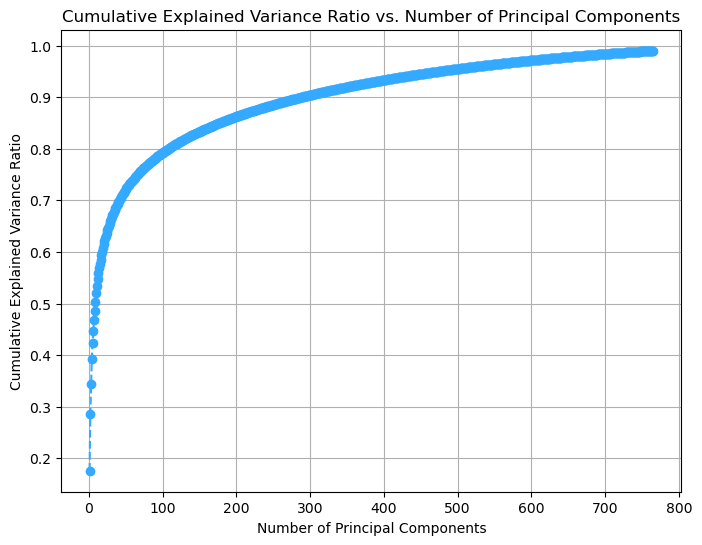

In [9]:
# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='#3af')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Pourquoi on a besoin du tsne pour la visu : en 2D ou même en 3D, les 3 premiers vecteurs propres
# # fournis par la PCA ne captent "que" (environ) un tiers de l'information.
# Ce qu'on verrait serait très déformé par les projections successives de la PCA.
# tester ?


### 0.8 tsne


In [10]:
# t-sne

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)


In [11]:
# encodage target

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(data["breed"])

data["target"] = label_encoder.transform(data["breed"])

display(data.head(1))
data.tail(1)


,photo_path,breed,width,height,resized,expo,contraste,denoised_g,denoised_bi,denoised_nl,preprocess_complet,target
0,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...,1


,photo_path,breed,width,height,resized,expo,contraste,denoised_g,denoised_bi,denoised_nl,preprocess_complet,target
941,./data/cleaned_data/0_format/-pomeranian/n0211...,pomeranian,500,376,./data/cleaned_data/1_resized_128/-pomeranian/...,./data/cleaned_data/2_expo_128/-pomeranian/n02...,./data/cleaned_data/3_contraste_128/-pomerania...,./data/cleaned_data/4_gauss_denoised_128/-pome...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-p...,./data/cleaned_data/7_preprocess_complet_128/-...,2


/tmp/ipykernel_403064/1681952556.py:5: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


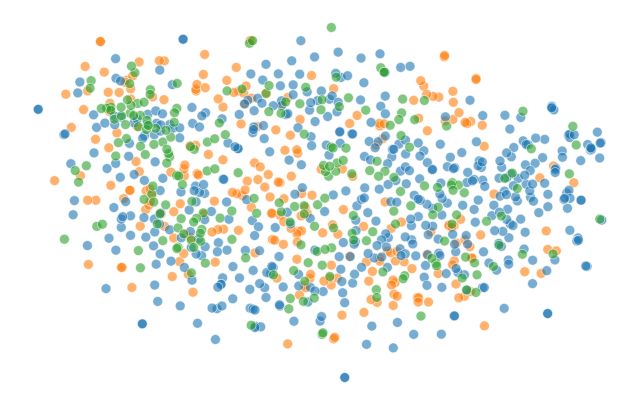

In [12]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["target"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=3), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

# plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
# plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
# plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
# plt.legend(prop={'size': 14})

plt.axis('off')  # Deactivate ticks
plt.legend().remove()  # Remove legend
plt.show()


# Ca marche moins bien sans extraction de features !
# On retentera en fin de notebook, en utilisant notre modèle.


## 1 Création d'un premier modèle


In [13]:
# Notre objectifs principal ici est
# de pouvoir observer / comprendre la fonction des différentes layers utilisées.

# Pour cela, nous allons commencer par une architecture très simple :
# le but n'est pas d'avoir le modèle le + performant possible.
# (irréaliste ici car on n'aurait ni le tps ni les ressources pour l'entrainer)
# (en revanche, voir le notebook 3, transfer learning, pour une comparaison de modèles + complexes)

# Première idée :
# Notre modèle de base sera donc inspiré d'AlexNet, dont l'architecture est :

# "AlexNet contains eight layers: the first five are convolutional layers,
# some of them followed by max-pooling layers, and the last three are fully connected layers.
# [...] The entire structure can be written as:

# (CNN -> RN -> MP)^2 -> (CNN^3 -> MP) -> (FC -> DO)^2 -> Linear -> softmax

# where
# CNN = convolutional layer (with ReLU activation)
# RN = local response normalization
# MP = maxpooling
# FC = fully connected layer (with ReLU activation)
# Linear = fully connected layer (without activation)
# DO = dropout

# It used the non-saturating ReLU activation function, which showed improved training performance
# over tanh and sigmoid." (wiki)


### 1.1 LeNet inspired architecture


In [14]:
# Problème : 8 groupes de layers... (16 individuelles, en fait) C'est déjà beaucoup !
# On peut faire + simple, au moins pour commencer.

# Voyons de quoi sera capable un modèle inspiré plutôt par LeNet-5
# et par ce notebook : https://www.kaggle.com/code/schmoyote/simple-cnn-architecture-for-image-classification/notebook


def model_v1():
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    # model.add(Dense(120, activation='tanh'))
    model.add(Dense(60, activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    return model


model = model_v1()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()


2024-04-01 00:13:35.238477: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 13456)             0         
                                                                 
 dense (Dense)               (None, 60)                8

### 1.2 feature engineering


In [15]:
feature = "photo_path"


def feature_to_array(feature="photo_path", norm=False, shape_result=False):
    """La preprocessing function pour notre modele"""
    X_feature = []

    for image_file in data[feature] :
        image = load_img(image_file, target_size=target_size)
        image = img_to_array(image)
        if norm:
            image = image / 255
        X_feature.append(image)

    X_feature = np.asarray(X_feature)

    if shape_result:
        pprint(X_feature[:1])
        print('\n', "Shape of X_train:", X_feature.shape)
        # ok

    return X_feature


X_feature = feature_to_array(shape_result=True)


array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [178., 198., 223.],
         [176., 196., 221.],
         [175., 195., 220.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [178., 198., 223.],
         [177., 197., 222.],
         [176., 196., 221.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [179., 199., 224.],
         [178., 198., 223.],
         [177., 197., 221.]],

        ...,

        [[188., 171., 155.],
         [133., 116., 100.],
         [152., 135., 119.],
         ...,
         [ 62.,  44.,  24.],
         [ 50.,  34.,  18.],
         [ 44.,  44.,  18.]],

        [[ 94.,  86.,  75.],
         [ 91.,  83.,  72.],
         [ 80.,  72.,  61.],
         ...,
         [111.,  94.,  78.],
         [160., 148., 134.],
         [178., 145., 128.]],

        [[208., 194., 181.],
       

### 1.3 label encoding target


In [16]:
y_target = np.asarray(data["target"])
print(y_target.shape)
pprint(y_target)


(942,)
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 1.4 train test split


In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=test_size,
                                                            shuffle=True, random_state=alea,
                                                            stratify=y_target) # important

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=test_size,
                                                            shuffle=True, random_state=alea,
                                                            stratify=y_train_val)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape, '\n')

print(y_train.shape)
print(y_val.shape)
print(y_test.shape, '\n')


(680, 128, 128, 3)
(120, 128, 128, 3)
(142, 128, 128, 3) 

(680,)
(120,)
(142,) 



### 1.5 one hot encoding (targets)


In [18]:
# One-hot encode target values after the split to avoid data leakage

y_train_ohe = tf.keras.utils.to_categorical(y_train)
y_val_ohe = tf.keras.utils.to_categorical(y_val)
y_test_ohe = tf.keras.utils.to_categorical(y_test)


### 1.6 Training


In [19]:
# Train the model
model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
          validation_data=(X_val, y_val_ohe), verbose=0) # verbose=0 avoids crashing cell later


### 1.7 Evaluation


In [20]:
# On overfit dès le début ??

# Evaluate the model
val_loss_ref, val_acc_ref = model.evaluate(X_val, y_val_ohe)
print(f'Val accuracy: {val_acc_ref}', '\n')

# En prédisant au hasard on aurait une chance sur 3, autrement dit
# ce modèle fait des prédictions quasi-aléatoires.
# Pas terrible, mais c'est un début !

# avant, tester sur photos d'origine (pour évaluer l'utilité du prétraitement effectué)



2/4 [==============>...............] - ETA: 0s - loss: 1.2498 - Accuracy: 0.4844

4/4 [==============================] - 0s 55ms/step - loss: 1.2368 - Accuracy: 0.4667
Val accuracy: 0.46666666865348816 



### save


In [21]:
parameters = {
    "model": "V1",
    "preprocessing": 'no_norm',
    "feature": feature,
    'target': f'{nb_classes}_classes',
    'dim images': f'{size_wh} x {size_wh} x 3',
    'size val test sets': test_size,
    'nb epochs': epochs
}


def save_model_if_better_than_the_best(model=model, acc=val_acc_ref, best_params=parameters):
    """Keeps track of our best current model"""

    global best_acc

    if acc > best_acc:
        print(f'Improving! Accuracy up to {acc}')
        best_acc = acc
        # erreur logging, saving instead
        # using mlflow
        # mlflow.keras.save_model(model, "./best_model") # works only once
        # using pickle
        with open(pickle_path_model, 'wb') as f:
            pickle.dump(model, f)
        # also save best accuracy
        with open(pickle_path_accuracy, 'wb') as f:
            pickle.dump(best_acc, f)
        # and corresponding best params
        with open(pickle_path_params, 'wb') as f:
            pickle.dump(best_params, f)


save_model_if_better_than_the_best()


In [22]:
# petit tracking manuel
results = {'model': 'V1',
            'df': 'data_3_classes',
            'feature': feature,
            'accuracy_val_moy': val_acc_ref,
            'time_fit': 'to do',
            'time_predict':'to do'
            }

# Append a new row for this model
model_results.append(results)


### 1.8 test utilité prétraitements


In [23]:
experiment_id = create_mlflow_experiment(
    experiment_name="analyse_pretraitements",
    artifact_location="./mlruns/artifacts",
    tags={"model": "V1", "preprocessing": 'no_norm', "features": "7_processed_features", 'target': '3_classes'},
)


Experiment analyse_pretraitements already exists.


In [24]:
# resized


def test_feature(df=data, feature='photo_path', epochs=epochs):
    """Test our model once, on a given feature"""
    parameters = {
        "model": "V1",
        "preprocessing": 'no_norm',
        "feature": feature,
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    # feature, target
    X_feature = feature_to_array(feature)
    y_target = np.asarray(df["target"])

    #tt split
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_target) # important

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_train_val)

    # ohe cible
    y_train_ohe = tf.keras.utils.to_categorical(y_train)
    y_val_ohe = tf.keras.utils.to_categorical(y_val)
    y_test_ohe = tf.keras.utils.to_categorical(y_test)

    # model
    model = model_v1()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

    model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
            validation_data=(X_val, y_val_ohe), verbose=0)

    _, val_acc = model.evaluate(X_val, y_val_ohe, verbose=0)

    save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

    metrix = {
        "accuracy_val": val_acc
    }
    # multiple metrics
    mlflow.log_metrics(metrix)

    print(f'Val accuracy (feature={feature}): {val_acc}')

    results = {'model': 'V1',
            'df': 'data_3_classes',
            'feature': feature,
            'accuracy_val_moy': val_acc,
            'time_fit': 'to do',
            'time_predict':'to do'
            }

    # Append a new row for this model
    model_results.append(results)

    return val_acc


# _ = test_feature(df=data, feature='resized')


# 0.6 de precision sans pretraitement (parfois 0.3 ??), 0.3 avec.
# Notre prétraitement semble (très) contre-productif. Ajuster dim, filtres ? (trop flou ?)
# Comme prétraitement, les méthodes .preprocessing() de keras consistent svt seulement en
# redimensionnemt + normalisation.
# faire pareil ?


In [25]:
# nested

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))

with mlflow.start_run(run_name="7_processed_features_once", experiment_id=experiment_id) as parent:
    all_metrics = {}

    for feature in features_to_test:
        print('\n', feature)
        with mlflow.start_run(run_name=f'{feature}', nested=True) as child:
            print(f'RUN ID child_{feature}: {child.info.run_id}')
            accuracy_val = test_feature(df=data, feature=feature)
            all_metrics[f'accuracy_{feature}'] = accuracy_val

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)

# results
# 'resized' 0.32 ???
# 'expo' 0.63
# 'contraste' 0.32

# rappel
print(f'\nRappel : Val accuracy (photo_path original) = {val_acc_ref}')


Name: analyse_pretraitements

 resized
RUN ID child_resized: 32d34989096d418bb1b3cb103a378c23


Val accuracy (feature=resized): 0.3176470696926117

 expo
RUN ID child_expo: 720a9398161a41cc8027e67ee44f2c13
Val accuracy (feature=expo): 0.4117647111415863

 contraste
RUN ID child_contraste: 64a666c5a6944f63ad697f689bc4579f
Val accuracy (feature=contraste): 0.5058823823928833

 denoised_g
RUN ID child_denoised_g: 7a235111342f4a7fba6cea3b95075ff0
Val accuracy (feature=denoised_g): 0.5176470875740051

 denoised_bi
RUN ID child_denoised_bi: 35fd1cc75c8d4adabe2c1c39c7a4ccad
Val accuracy (feature=denoised_bi): 0.48235294222831726

 denoised_nl
RUN ID child_denoised_nl: 6bdac84220b2480199094232d9c90100
Val accuracy (feature=denoised_nl): 0.529411792755127

 preprocess_complet
RUN ID child_preprocess_complet: 02bec052d964427aafc7b870b6e72697
Val accuracy (feature=preprocess_complet): 0.43529412150382996


{'accuracy_contraste': 0.5058823823928833,
 'accuracy_denoised_bi': 0.48235294222831726,
 'accuracy_denoised_g': 0.5176470875740051,
 'accuracy_denoised_nl': 0.529411792755127,
 'accuracy

### Comparaison


In [26]:
affichage_results(multiple=False, best_acc=best_acc)

# On y voit déjà (un peu) + clair :
# Chaque étape de notre prétraitement semble + ou - détériorer la qualité des prédictions.

# Encore que... ?
# ??? resized et photo_path devraient donner des résultats bien + proches, non ??
# sets identiques sauf dim, et redim lors de création de X_feature
# ... devraient être exactement identiques, et donc avoir des resultats proches

# En fait d'un run à l'autre, les prédictions varient énormément...
# difficile du coup d'évaluer l'impact de nos prétraitements.
# moyenne sur +ieurs runs ?

model_results = []

# (Très) svt le modèle ne parvient pas à "train ses layers", et l'accuracy des prédictions
# sur le jeu de validation reste au niveau de prédictions random.


4 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.6000000238418579


,model,df,feature,accuracy_val_moy,time_fit,time_predict
6,V1,data_3_classes,denoised_nl,0.529412,to do,to do
4,V1,data_3_classes,denoised_g,0.517647,to do,to do
3,V1,data_3_classes,contraste,0.505882,to do,to do
5,V1,data_3_classes,denoised_bi,0.482353,to do,to do
0,V1,data_3_classes,photo_path,0.466667,to do,to do
7,V1,data_3_classes,preprocess_complet,0.435294,to do,to do
2,V1,data_3_classes,expo,0.411765,to do,to do
1,V1,data_3_classes,resized,0.317647,to do,to do


### Mean multiple runs


In [27]:
experiment_id = create_mlflow_experiment(
    experiment_name='analyse_pretraitmt_multiple_runs',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V1", "preprocessing": 'no_norm', "features": "all_8_features", 'target': '3_classes'},
)


Experiment analyse_pretraitmt_multiple_runs already exists.


In [28]:
#


def test_feature_n_times(feature='photo_path', epochs=epochs, n=nb_runs):
    """Test a given feature multiple times"""
    parameters = {
        "model": "V1",
        "preprocessing": 'no_norm',
        "feature": feature,
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters) # child

    results_val_acc, results_time_fit,  results_time_predict = [], [], []

    for i in range(n):

        with mlflow.start_run(run_name=f'run_{i}', nested=True) as grand_kid:
            print(f'\nRun {i}\n')
            print("RUN ID ", grand_kid.info.run_id )
            mlflow.log_params(parameters) # grand_kid

            # feature, target
            X_feature = feature_to_array(feature)
            y_target = np.asarray(data["target"])

            X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_target) # important

            X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_train_val)

            y_train_ohe = tf.keras.utils.to_categorical(y_train)
            y_val_ohe = tf.keras.utils.to_categorical(y_val)
            y_test_ohe = tf.keras.utils.to_categorical(y_test)

            # model
            model = model_v1()

            # Compile the model
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            # fit model and time it
            time_fit_start = time.time() # returns the time in seconds since the epoch.
            model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                    validation_data=(X_val, y_val_ohe), verbose=0)
            time_fit_end = time.time()
            time_fit = time_fit_end - time_fit_start

            # time predictions
            time_predict_start = time.time()
            _, val_acc = model.evaluate(X_val, y_val_ohe) # , verbose=0 ?
            time_predict_end = time.time()
            time_predict = time_predict_end - time_predict_start

            # print(f'Val accuracy (feature={feature}): {val_acc}')

            save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

            metriq = {
                "accuracy_val": val_acc,
                "time_fit": time_fit,
                "time_predict": time_predict
            }
            mlflow.log_metrics(metriq)

            results_val_acc.append(val_acc)
            results_time_fit.append(time_fit)
            results_time_predict.append(time_predict)

            # Log the model doesn't work ??
            # mlflow.keras.log_model(model=model, artifact_path="good_model",registered_model_name='best_model')

    # moyennes
    mean_val_acc = np.mean(results_val_acc)
    mean_time_fit = np.mean(results_time_fit)
    mean_time_predict = np.mean(results_time_predict)

    # écarts-types (utile ici pour le score, afin d'avoir une idée de la "régularité" des résultats)
    # les tps d'entrainement / prédiction st bcp + stables
    std_val_acc = np.std(results_val_acc)

    metrix = {
        "accuracy_val_moy": mean_val_acc,
        "accuracy_val_std": std_val_acc,
        "time_fit_moy": mean_time_fit,
        "time_predict_moy": mean_time_predict
    }
    for run in range(nb_runs):
        metrix[f'accuracy_val_run_{run}'] = results_val_acc[run]

    # multiple metrics
    mlflow.log_metrics(metrix)

    results = {'model': 'V1',
        'df': 'data_3_classes',
        'feature': feature,
        'accuracy_val_moy': mean_val_acc,
        'accuracy_val_std': std_val_acc,
        'time_fit_moy (s)': mean_time_fit,
        'time_predict_moy (s)': mean_time_predict,
        }

    # Append a new row for this model
    model_results.append(results)

    print('\n', f'Accuracy val {feature}, moyenne : {mean_val_acc}')
    print(f'Accuracy val {feature}, écart-type : {std_val_acc}')

    # + tard
    # log model
    # mlflow.sklearn.log_model(sk_model=knn_ref, artifact_path="special_knn")

     # Save a plot
    # plt.savefig("./artifacts/jaccard_plot_3_4_tags.png")
    # Log the saved figure using MLflow
    # mlflow.log_artifact("./artifacts/jaccard_plot_3_4_tags.png")

    return metrix


# _ = test_feature_n_times()

#


In [29]:
# nested

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


with mlflow.start_run(run_name="test_all_8_features", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V1",
        "preprocessing": 'no_norm',
        "feature": feature,
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters) # parent

    all_metrics = {}

    for feature in all_features_to_test:
        print('\n', feature)
        with mlflow.start_run(run_name=f'{feature}', nested=True) as child:
            print(f'RUN ID child_{feature}: {child.info.run_id}', '\n')
            metrix = test_feature_n_times(feature=feature)
            all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics) # perfect


# results
# 'resized' 0.32 ???
# 'expo' 0.63
# 'contraste' 0.32


Name: analyse_pretraitmt_multiple_runs

 photo_path
RUN ID child_photo_path: fcdca90336f6487186023b159b447c78 


Run 0

RUN ID  95e712710be6483f8e29b1c176683c77


3/3 [==============================] - 0s 55ms/step - loss: 1.3853 - accuracy: 0.2706

Run 1

RUN ID  352133aa21d74385b4b8c05be7bdc094
3/3 [==============================] - 0s 54ms/step - loss: 1.3852 - accuracy: 0.2706

Run 2

RUN ID  0464488d8eb24823a835506b51ffc5cf
3/3 [==============================] - 0s 87ms/step - loss: 1.3852 - accuracy: 0.2706

Run 3

RUN ID  2d869c5ab5b94f0782899d0b62acddeb
3/3 [==============================] - 0s 26ms/step - loss: 1.3858 - accuracy: 0.2706

Run 4

RUN ID  529e9901b9ea4619a337859f7a4c3afb
3/3 [==============================] - 0s 48ms/step - loss: 1.3862 - accuracy: 0.2471

Run 5

RUN ID  319783b1950c4fd4830c1edb36ae2f92
3/3 [==============================] - 0s 42ms/step - loss: 1.1637 - accuracy: 0.4941

Run 6

RUN ID  30db9ec30f7e485b99e22dcee62c9a5d
3/3 [==============================] - 0s 41ms/step - loss: 1.3860 - accuracy: 0.2471

Run 7

RUN ID  acb53825c8764ce9b9ee8c74fe10bf04
3/3 [==============================] - 0s 20ms/step - l

In [30]:
affichage_results(best_acc=best_acc)

# Enfin des résultats interprétables !
# Cpdt le nb de runs est encore très faible, et les résultats st très proches.

# model_results = []

# log / picle model. size ?

# les pretraitements expo / contraste semblent bénéfiques,
# en revanche le filtre gaussien mm léger ici semble avoir un impact légèrement négatif
# sur les prédictions du modèle. Le modèle n'aime pas le flou !

# (encore une fois, ces "conclusions" sont à prendre "avec des pincettes", en attendant
# des runs supplémentaires.)


4 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.6235294342041016
nb runs: 10 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
3,V1,data_3_classes,contraste,0.418824,0.088697,51.939729,0.266466
6,V1,data_3_classes,denoised_nl,0.396471,0.118240,51.621158,0.268431
1,V1,data_3_classes,resized,0.388235,0.094411,51.264873,0.236963
7,V1,data_3_classes,preprocess_complet,0.380000,0.116114,54.298011,0.318968
2,V1,data_3_classes,expo,0.377647,0.132837,53.117061,0.245825
4,V1,data_3_classes,denoised_g,0.330588,0.082764,51.278844,0.273004
0,V1,data_3_classes,photo_path,0.329412,0.104302,56.093079,0.251781
5,V1,data_3_classes,denoised_bi,0.305882,0.089906,55.851431,0.253189


In [31]:
# A propos de la fonction d'activation tanh

# Choisi tanh pour commencer, une fonction d'activation "historique",
# +tôt que relu (+ utilisée dans les archis des modèles + récents)
# parce que la tangeante hyperbolique agit comme un scaler :
# Elle centre les valeurs autour de 0, sur l'intervalle [-1, 1]

# du coup pas besoin de normaliser nos pixels au préalable.
# Quand on testera relu, il faudra comparer avec ou sans normalisation.

# Autre caractéristique intéressante de la fonction tanh :

# La symétrie par rapport à l'origine + normalisation peuvent aider les algorithmes à optimiser le modèle,
# en empêchant les gradients de devenir trop proches de 0 (problème fréquent du 'vanishing gradient')
# ou au contraire trop importants ('exploding gradient') pdt la backpropagation.
# Il est cpdt tjs possible de rencontrer un vanishing gradient.


## 2 Ameliorations


In [32]:
# 3 pistes -> améliorations possibles :

# retour au preprocessing,
# data augmentation,
# améliorer le model lui-même.

# Nous allons commencer par le modèle, car parvenir à obtenir un modèle + consistent
# (= faire baisser la sdt) rendrait l'analyse des pretraitements et de la data augmentation
# bcp + fiable.


### 2.1 keras-tuner, archi 1


In [33]:
experiment_id = create_mlflow_experiment(
    experiment_name='keras_tuner_1_archi',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V2", "preprocessing": 'no_norm', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment keras_tuner_1_archi already exists.
Name: keras_tuner_1_archi


In [34]:
# tester Optuna ? (compatible sk-learn + tracking ui)
# kt très facile à intégrer ici, puisque nous utilisons uniquement keras
# syntaxe légèrement + simple (mais les 2 st assez proches)
# (sauf / f1score ?)

# Commençons par qq hyperparams de l'architecture générale de notre modèle :
# (On espère "alléger" le modèle, pour le rendre plus facile a entrainer.)
# nb de filtres (pour les 2 couches de convolution)
# nb neurons (first fully-connected layer)


def build_model(hp):

    model = Sequential()
    model.add(Conv2D(hp.Int("conv_1_units", min_value=4, max_value=32, step=4),
                     kernel_size=(5, 5), activation='tanh', input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int("conv_2_units", min_value=4, max_value=32, step=4),
                     kernel_size=(5, 5), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int("dense_units", min_value=32, max_value=192, step=32), activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def test_archi_n_times(feature='photo_path', epochs=epochs, n=nb_runs, model_name='V2_kt',
                       norm=False, dir='keras_tuner/archi_1'):

    tuner = kt.Hyperband(build_model,
                         objective='val_accuracy',
                         max_epochs=epochs,
                         factor=3,
                         directory=dir,
                         project_name=model_name)

    results_val_acc, results_time_fit,  results_time_predict = [], [], []

    for i in range(n):
        with mlflow.start_run(run_name=f'run_{i}', nested=True) as kid:
            print(f'\nRun {i}\n')
            print("RUN ID ", kid.info.run_id)

            # feature, target
            X_feature = feature_to_array(feature, norm=norm)
            y_target = np.asarray(data["target"])

            X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_target) # important

            X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_train_val)

            y_train_ohe = tf.keras.utils.to_categorical(y_train)
            y_val_ohe = tf.keras.utils.to_categorical(y_val)
            y_test_ohe = tf.keras.utils.to_categorical(y_test)

            tuner.search(X_train, y_train_ohe, validation_data=(X_val, y_val_ohe))

            # Get the optimal hyperparameters
            best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

            # Build the model with the optimal hyperparameters
            model = tuner.hypermodel.build(best_hps)

            # Fit model and time it
            time_fit_start = time.time()
            model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                    validation_data=(X_val, y_val_ohe), verbose=0)
            time_fit_end = time.time()
            time_fit = time_fit_end - time_fit_start

            # Time predictions
            time_predict_start = time.time()
            _, val_acc = model.evaluate(X_val, y_val_ohe) # , verbose=0 ?
            time_predict_end = time.time()
            time_predict = time_predict_end - time_predict_start

            # print(f'Val accuracy (feature={feature}): {val_acc}', '\n')

            parameters.update(best_hps.values)
            mlflow.log_params(parameters)

            save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

            metriq = {
                "accuracy_val": val_acc,
                "time_fit": time_fit,
                "time_predict": time_predict
            }
            mlflow.log_metrics(metriq)


            results_val_acc.append(val_acc)
            results_time_fit.append(time_fit)
            results_time_predict.append(time_predict)

    # Calculate averages
    mean_val_acc = np.mean(results_val_acc)
    mean_time_fit = np.mean(results_time_fit)
    mean_time_predict = np.mean(results_time_predict)

    # Calculate standard deviations
    std_val_acc = np.std(results_val_acc)

    metrix = {
        "accuracy_val_moy": mean_val_acc,
        "accuracy_val_std": std_val_acc,
        "time_fit_moy": mean_time_fit,
        "time_predict_moy": mean_time_predict
    }
    for run in range(nb_runs):
        metrix[f'accuracy_val_run_{run}'] = results_val_acc[run]

    # multiple metrics
    mlflow.log_metrics(metrix)

    results = {'model': model_name,
               'df': 'data_3_classes',
               'feature': feature,
               'accuracy_val_moy': mean_val_acc,
               'accuracy_val_std': std_val_acc,
               'time_fit_moy (s)': mean_time_fit,
               'time_predict_moy (s)': mean_time_predict,
              }

    # Append a new row for this model
    model_results.append(results)

    print(f'Accuracy val {feature}, moyenne : {mean_val_acc}')
    print(f'Accuracy val {feature}, écart-type : {std_val_acc}', '\n')

    print("Best Hyperparameters:")
    print(best_hps.values)

    return metrix


#  _ = test_archi_n_times()

# wow
# Reloading Tuner from keras_tuner_dir/test_kt/tuner0.json
# kt ne perd pas de tps et récupère directement les hyperparamètres
# Au final il semble légèrement + rapide d'utiliser kt !


In [35]:
with mlflow.start_run(run_name="test_archi_1", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V2",
        "preprocessing": 'no_norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_archi_n_times()

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)


Reloading Tuner from keras_tuner/archi_1/V2_kt/tuner0.json

Run 0

RUN ID  47a0ae364152456c9e25e31b9ff69e76


3/3 [==============================] - 0s 52ms/step - loss: 1.3900 - accuracy: 0.2706

Run 1

RUN ID  78cb012e115649cb8fa5bfb69487b0ad
3/3 [==============================] - 0s 48ms/step - loss: 1.1928 - accuracy: 0.5294

Run 2

RUN ID  2dead4dad1e04682ab1f67f2b6493291
3/3 [==============================] - 0s 53ms/step - loss: 1.3897 - accuracy: 0.2471

Run 3

RUN ID  5fb591a1f74d48ba9998d31b46ea7484
3/3 [==============================] - 0s 69ms/step - loss: 1.4145 - accuracy: 0.2471

Run 4

RUN ID  add239e6ad904c3ca7a5f3255b1d4624
3/3 [==============================] - 0s 69ms/step - loss: 1.3941 - accuracy: 0.2471

Run 5

RUN ID  70381eb4139749c2bb65031bf164fc6b
3/3 [==============================] - 0s 57ms/step - loss: 1.3957 - accuracy: 0.2706

Run 6

RUN ID  1e637c399df84990bcc7d666d4348704
3/3 [==============================] - 0s 68ms/step - loss: 1.3975 - accuracy: 0.2471

Run 7

RUN ID  afaa5ac17f81425296957514c6facd30
3/3 [==============================] - 0s 60ms/step - l

In [36]:
affichage_results(best_acc=best_acc)

# Enfin un écart significatif !
# std tjs élevé (tjs l'aléatoire / initialisation)


4 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.6235294342041016
nb runs: 10 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
3,V1,data_3_classes,contraste,0.418824,0.088697,51.939729,0.266466
6,V1,data_3_classes,denoised_nl,0.396471,0.118240,51.621158,0.268431
1,V1,data_3_classes,resized,0.388235,0.094411,51.264873,0.236963
7,V1,data_3_classes,preprocess_complet,0.380000,0.116114,54.298011,0.318968
2,V1,data_3_classes,expo,0.377647,0.132837,53.117061,0.245825
4,V1,data_3_classes,denoised_g,0.330588,0.082764,51.278844,0.273004
0,V1,data_3_classes,photo_path,0.329412,0.104302,56.093079,0.251781
5,V1,data_3_classes,denoised_bi,0.305882,0.089906,55.851431,0.253189
8,V2_kt,data_3_classes,photo_path,0.285882,0.082193,83.390735,0.302783


### 2.2 keras-tuner, fonction d'activation


In [37]:
experiment_id = create_mlflow_experiment(
    experiment_name='keras_tuner_2_activation',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V3", "preprocessing": 'no_norm', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment keras_tuner_2_activation already exists.
Name: keras_tuner_2_activation


In [38]:
# Continuons en testant la fonction d'activation relu

# tester Optuna ? (compatible sk-learn)
# kt très facile à intégrer ici, puisque nous utilisons uniquement keras
# (sauf / f1score ?)

# Commençons par qq hyperparams de l'architecture générale de notre modèle :
# nb de filtres (pour les 2 couches de convolution)
# nb neurons (first fully-connected layer)

def build_model(hp):

    model = Sequential()
    model.add(Conv2D(hp.Int("conv_1_units", min_value=4, max_value=32, step=4),kernel_size=(5, 5),
                     activation=hp.Choice("activation", ["relu", "tanh"]),
                     input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int("conv_2_units", min_value=4, max_value=32, step=4),
                     kernel_size=(5, 5), activation=hp.Choice("activation", ["relu", "tanh"])))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(hp.Int("dense_units", min_value=32, max_value=192, step=32),
                    activation=hp.Choice("activation", ["relu", "tanh"])))
    model.add(Dense(nb_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


with mlflow.start_run(run_name="test_activation", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V3",
        "preprocessing": 'no_norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_archi_n_times(model_name='V3_kt_activ', dir='keras_tuner/activ')

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)


# {'conv_1_units': 28, 'activation': 'tanh', 'conv_2_units': 4, 'dense_units': 96


Reloading Tuner from keras_tuner/activ/V3_kt_activ/tuner0.json

Run 0

RUN ID  ddaee70d6db14892b4872a643c653934


3/3 [==============================] - 0s 41ms/step - loss: 1.2316 - accuracy: 0.4353

Run 1

RUN ID  2613845529b64a3092871b5886e7f245
3/3 [==============================] - 0s 84ms/step - loss: 1.2625 - accuracy: 0.5176

Run 2

RUN ID  81c9ff36882348a7a82966020a5cc609
3/3 [==============================] - 0s 88ms/step - loss: 1.4454 - accuracy: 0.5412

Run 3

RUN ID  55f86c80c502493ebaae3161de891aed
3/3 [==============================] - 0s 50ms/step - loss: 1.0660 - accuracy: 0.5176

Run 4

RUN ID  17a5d8cdaf7b41038e2624fd2e13c1d5
3/3 [==============================] - 0s 130ms/step - loss: 1.3966 - accuracy: 0.2471

Run 5

RUN ID  6ed24d69d91744f4b427ad77e39bf700
3/3 [==============================] - 0s 53ms/step - loss: 1.3165 - accuracy: 0.5765

Run 6

RUN ID  fe4efaef86f84ee8a55f1d6299ff1b7d
3/3 [==============================] - 0s 60ms/step - loss: 1.4033 - accuracy: 0.2706

Run 7

RUN ID  13dedc7f691d456b9d5700d6b973e436
3/3 [==============================] - 0s 53ms/step - 

In [39]:
affichage_results(best_acc=best_acc)

# tjs très aléatoire.
# std ?

# relu sans normalisation ici


4 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.6235294342041016
nb runs: 10 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
9,V3_kt_activ,data_3_classes,photo_path,0.436471,0.123999,71.382794,0.313036
3,V1,data_3_classes,contraste,0.418824,0.088697,51.939729,0.266466
6,V1,data_3_classes,denoised_nl,0.396471,0.118240,51.621158,0.268431
1,V1,data_3_classes,resized,0.388235,0.094411,51.264873,0.236963
7,V1,data_3_classes,preprocess_complet,0.380000,0.116114,54.298011,0.318968
2,V1,data_3_classes,expo,0.377647,0.132837,53.117061,0.245825
4,V1,data_3_classes,denoised_g,0.330588,0.082764,51.278844,0.273004
0,V1,data_3_classes,photo_path,0.329412,0.104302,56.093079,0.251781
5,V1,data_3_classes,denoised_bi,0.305882,0.089906,55.851431,0.253189
8,V2_kt,data_3_classes,photo_path,0.285882,0.082193,83.390735,0.302783


### 2.3 normalisation + fonction d'activation


In [40]:
experiment_id = create_mlflow_experiment(
    experiment_name='keras_tuner_2_activation_norm',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V3", "preprocessing": 'normalisation', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment keras_tuner_2_activation_norm already exists.
Name: keras_tuner_2_activation_norm


In [41]:
with mlflow.start_run(run_name="activation_norm", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V3",
        "preprocessing": 'norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_archi_n_times(model_name='V3_kt_activ_norm', norm=True, dir='keras_tuner/norm_activ')

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)


Reloading Tuner from keras_tuner/norm_activ/V3_kt_activ_norm/tuner0.json

Run 0

RUN ID  a78cd28c59424cd08eb7e66c5bb8011a


3/3 [==============================] - 0s 33ms/step - loss: 1.0744 - accuracy: 0.5059

Run 1

RUN ID  6a0cb5ef529f412c94ea77da743ab228
3/3 [==============================] - 0s 90ms/step - loss: 1.6018 - accuracy: 0.5882

Run 2

RUN ID  a6b71f518e494b37b6cb951280f45964
3/3 [==============================] - 0s 44ms/step - loss: 1.2035 - accuracy: 0.5294

Run 3

RUN ID  88cc6a4e729d4fec85a43de4e0280f2c
3/3 [==============================] - 0s 69ms/step - loss: 1.7383 - accuracy: 0.5412

Run 4

RUN ID  350979280c264757a3084707dfe9cc35
3/3 [==============================] - 0s 58ms/step - loss: 1.6980 - accuracy: 0.5412

Run 5

RUN ID  b45438a2182a49aeb1382c5698309e9c
3/3 [==============================] - 0s 102ms/step - loss: 1.2504 - accuracy: 0.5294

Run 6

RUN ID  84b51b527ea347f4b42871912ff55cc6
3/3 [==============================] - 0s 97ms/step - loss: 1.3925 - accuracy: 0.2706

Run 7

RUN ID  d3cfa236900c403a986d48a8494090fa
3/3 [==============================] - 0s 70ms/step - 

In [42]:
affichage_results(best_acc=best_acc)


4 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.6235294342041016
nb runs: 10 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
10,V3_kt_activ_norm,data_3_classes,photo_path,0.503529,0.089566,90.360291,0.307309
9,V3_kt_activ,data_3_classes,photo_path,0.436471,0.123999,71.382794,0.313036
3,V1,data_3_classes,contraste,0.418824,0.088697,51.939729,0.266466
6,V1,data_3_classes,denoised_nl,0.396471,0.118240,51.621158,0.268431
1,V1,data_3_classes,resized,0.388235,0.094411,51.264873,0.236963
7,V1,data_3_classes,preprocess_complet,0.380000,0.116114,54.298011,0.318968
2,V1,data_3_classes,expo,0.377647,0.132837,53.117061,0.245825
4,V1,data_3_classes,denoised_g,0.330588,0.082764,51.278844,0.273004
0,V1,data_3_classes,photo_path,0.329412,0.104302,56.093079,0.251781
5,V1,data_3_classes,denoised_bi,0.305882,0.089906,55.851431,0.253189


### 2.4 optuna


In [43]:
experiment_id = create_mlflow_experiment(
    experiment_name='optuna_1_activ',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V4", "preprocessing": 'no_norm', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment optuna_1_activ already exists.
Name: optuna_1_activ


In [44]:
# Contrairement à keras tuner, qui sauvegarde par défaut le résultat obtenu sur le disque,
# optuna refait les tests à chaque run


def build_model(conv_1_units, filter1, conv_2_units, filter2, fc_1_units):
    model = Sequential()
    model.add(Conv2D(conv_1_units, kernel_size=(filter1, filter1),
                     activation="tanh",
                     input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(conv_2_units, kernel_size=(filter2, filter2),
                     activation="tanh"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(fc_1_units, activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Accuracy'])

    return model


def objective(trial, X_train, y_train_ohe, X_val, y_val_ohe):
    # Define a pruning callback
    pruning_callback = TFKerasPruningCallback(trial, "val_Accuracy")

    # Parameters to optimize
    conv_1_units = trial.suggest_int('conv_1_units', 4, 32, step=4)
    filter1 = trial.suggest_int('filter1', 3, 5, step=2)
    conv_2_units = trial.suggest_int('conv_2_units', 4, 32, step=4)
    filter2 = trial.suggest_int('filter2', 3, 5, step=2)
    fc_1_units = trial.suggest_int('fc_1_units', 10, 100, step=10)

    # Build and compile the model with the suggested parameters
    model = build_model(conv_1_units, filter1, conv_2_units, filter2, fc_1_units)

    # Train the model
    history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                        validation_data=(X_val, y_val_ohe),
                        callbacks=[pruning_callback], verbose=0)

    # Evaluate the model on the validation set
    val_acc = history.history['val_Accuracy'][-1]

    return val_acc


def test_optuna_n_times(feature='photo_path', epochs=epochs, n=nb_runs, norm=True, model_name='V4_optuna'):
    results_val_acc, results_time_fit,  results_time_predict = [], [], []

    for i in range(n):
        with mlflow.start_run(run_name=f'run_{i}', nested=True) as kid:
            print(f'\nRun {i}\n')
            print("RUN ID ", kid.info.run_id)

            # feature, target
            X_feature = feature_to_array(feature, norm=norm)
            y_target = np.asarray(data["target"])

            X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_target)

            X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_train_val)

            y_train_ohe = tf.keras.utils.to_categorical(y_train)
            y_val_ohe = tf.keras.utils.to_categorical(y_val)
            y_test_ohe = tf.keras.utils.to_categorical(y_test)

            # Create a partially applied objective function with fixed arguments
            partial_objective = partial(objective, X_train=X_train, y_train_ohe=y_train_ohe, X_val=X_val, y_val_ohe=y_val_ohe)

            study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
            study.optimize(partial_objective, n_trials=10)

            # plot_optimization_history(study)

            # Fetch the best parameters
            best_trial = study.best_trial
            best_params = best_trial.params

            # Build the model with the best parameters
            model = build_model(**best_params)

            # Fit model and time it
            time_fit_start = time.time()
            model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                    validation_data=(X_val, y_val_ohe), verbose=0)
            time_fit_end = time.time()
            time_fit = time_fit_end - time_fit_start

            # Time predictions
            time_predict_start = time.time()
            _, val_acc = model.evaluate(X_val, y_val_ohe)
            time_predict_end = time.time()
            time_predict = time_predict_end - time_predict_start

            # print(f'Val accuracy (feature={feature}): {val_acc}')

            parameters.update(best_params)
            mlflow.log_params(parameters)

            save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

            metriq = {
                "accuracy_val": val_acc,
                "time_fit": time_fit,
                "time_predict": time_predict
            }
            mlflow.log_metrics(metriq)

            results_val_acc.append(val_acc)
            results_time_fit.append(time_fit)
            results_time_predict.append(time_predict)

    # Calculate averages
    mean_val_acc = np.mean(results_val_acc)
    mean_time_fit = np.mean(results_time_fit)
    mean_time_predict = np.mean(results_time_predict)

    # Calculate standard deviations
    std_val_acc = np.std(results_val_acc)

    metrix = {
        "accuracy_val_moy": mean_val_acc,
        "accuracy_val_std": std_val_acc,
        "time_fit_moy": mean_time_fit,
        "time_predict_moy": mean_time_predict
    }
    for run in range(nb_runs):
        metrix[f'accuracy_val_run_{run}'] = results_val_acc[run]

    # multiple metrics
    mlflow.log_metrics(metrix)

    results = {'model': model_name,
               'df': 'data_3_classes',
               'feature': feature,
               'accuracy_val_moy': mean_val_acc,
               'accuracy_val_std': std_val_acc,
               'time_fit_moy (s)': mean_time_fit,
               'time_predict_moy (s)': mean_time_predict,
              }

    # Append a new row for this model
    model_results.append(results)

    print('\n', f'Accuracy val {feature}, moyenne : {mean_val_acc}')
    print(f'Accuracy val {feature}, écart-type : {std_val_acc}')

    return metrix


# _ = test_optuna_n_times()


In [45]:
with mlflow.start_run(run_name="optuna_1", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V4_optuna",
        "preprocessing": 'norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_optuna_n_times()

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)



Run 0

RUN ID  c652e0331c65414c9c99a04da9ddf1d0


[I 2024-04-01 02:19:46,176] A new study created in memory with name: no-name-000ecf33-e69c-4068-b457-f4cc8db6bf62
[I 2024-04-01 02:21:10,854] Trial 0 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 28, 'filter1': 3, 'conv_2_units': 8, 'filter2': 5, 'fc_1_units': 70}. Best is trial 0 with value: 0.5411764979362488.
[I 2024-04-01 02:22:38,633] Trial 1 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 20, 'filter2': 5, 'fc_1_units': 40}. Best is trial 0 with value: 0.5411764979362488.
[I 2024-04-01 02:23:26,781] Trial 2 finished with value: 0.5529412031173706 and parameters: {'conv_1_units': 4, 'filter1': 5, 'conv_2_units': 8, 'filter2': 5, 'fc_1_units': 40}. Best is trial 2 with value: 0.5529412031173706.
[I 2024-04-01 02:24:35,285] Trial 3 finished with value: 0.5176470875740051 and parameters: {'conv_1_units': 12, 'filter1': 5, 'conv_2_units': 24, 'filter2': 3, 'fc_1_units': 50}. Best is trial 2 with valu

3/3 [==============================] - 0s 55ms/step - loss: 1.6330 - accuracy: 0.5412

Run 1

RUN ID  a72dabbdcc834221a8ae6ff346cbd5c8


[I 2024-04-01 02:28:20,744] A new study created in memory with name: no-name-e496cca3-8510-4571-a640-a4d5f89ef713
[I 2024-04-01 02:29:12,401] Trial 0 finished with value: 0.5529412031173706 and parameters: {'conv_1_units': 8, 'filter1': 3, 'conv_2_units': 8, 'filter2': 5, 'fc_1_units': 20}. Best is trial 0 with value: 0.5529412031173706.
[I 2024-04-01 02:30:17,610] Trial 1 finished with value: 0.5647059082984924 and parameters: {'conv_1_units': 8, 'filter1': 5, 'conv_2_units': 24, 'filter2': 5, 'fc_1_units': 30}. Best is trial 1 with value: 0.5647059082984924.
[I 2024-04-01 02:31:40,796] Trial 2 finished with value: 0.4941176474094391 and parameters: {'conv_1_units': 32, 'filter1': 5, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 40}. Best is trial 1 with value: 0.5647059082984924.
[I 2024-04-01 02:32:32,701] Trial 3 finished with value: 0.5529412031173706 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 16, 'filter2': 5, 'fc_1_units': 50}. Best is trial 1 with value:

[I 2024-04-01 02:34:37,101] Trial 8 pruned. Trial was pruned at epoch 0.


[I 2024-04-01 02:34:42,594] Trial 9 pruned. Trial was pruned at epoch 0.


3/3 [==============================] - 0s 35ms/step - loss: 1.3851 - accuracy: 0.2706

Run 2

RUN ID  c9418e9eea4e4b65ae1a05cf9e8e49ba


[I 2024-04-01 02:35:52,875] A new study created in memory with name: no-name-409fb4b4-62a1-4966-bc7e-a4113dd31c97
[I 2024-04-01 02:36:39,363] Trial 0 finished with value: 0.6000000238418579 and parameters: {'conv_1_units': 8, 'filter1': 5, 'conv_2_units': 4, 'filter2': 3, 'fc_1_units': 10}. Best is trial 0 with value: 0.6000000238418579.
[I 2024-04-01 02:38:03,149] Trial 1 finished with value: 0.5764706134796143 and parameters: {'conv_1_units': 28, 'filter1': 5, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 60}. Best is trial 0 with value: 0.6000000238418579.
[I 2024-04-01 02:39:06,823] Trial 2 finished with value: 0.5176470875740051 and parameters: {'conv_1_units': 4, 'filter1': 5, 'conv_2_units': 28, 'filter2': 5, 'fc_1_units': 50}. Best is trial 0 with value: 0.6000000238418579.
[I 2024-04-01 02:40:32,432] Trial 3 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 24, 'filter1': 3, 'conv_2_units': 12, 'filter2': 5, 'fc_1_units': 100}. Best is trial 0 with valu

3/3 [==============================] - 0s 29ms/step - loss: 1.3902 - accuracy: 0.4706

Run 3

RUN ID  1dcafb7a111143a1a70e6c8156568ba2


[I 2024-04-01 02:45:14,003] A new study created in memory with name: no-name-d66cd47a-c7aa-46e6-806f-555c8c9255fd
[I 2024-04-01 02:45:56,421] Trial 0 finished with value: 0.5058823823928833 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 4, 'filter2': 3, 'fc_1_units': 20}. Best is trial 0 with value: 0.5058823823928833.
[I 2024-04-01 02:47:51,619] Trial 1 finished with value: 0.2705882489681244 and parameters: {'conv_1_units': 32, 'filter1': 3, 'conv_2_units': 32, 'filter2': 5, 'fc_1_units': 40}. Best is trial 0 with value: 0.5058823823928833.
[I 2024-04-01 02:49:06,987] Trial 2 finished with value: 0.5058823823928833 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 28, 'filter2': 3, 'fc_1_units': 60}. Best is trial 0 with value: 0.5058823823928833.
[I 2024-04-01 02:50:31,799] Trial 3 finished with value: 0.529411792755127 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_units': 16, 'filter2': 3, 'fc_1_units': 100}. Best is trial 3 with val

3/3 [==============================] - 0s 67ms/step - loss: 1.5295 - accuracy: 0.6000

Run 4

RUN ID  7afc2d9a99d24682bdd3f4b853e1c5a5


[I 2024-04-01 02:57:25,274] A new study created in memory with name: no-name-eed878d4-561c-412f-8fa1-363facb092ce
[I 2024-04-01 02:58:48,948] Trial 0 finished with value: 0.529411792755127 and parameters: {'conv_1_units': 20, 'filter1': 5, 'conv_2_units': 28, 'filter2': 3, 'fc_1_units': 40}. Best is trial 0 with value: 0.529411792755127.
[I 2024-04-01 03:00:11,763] Trial 1 finished with value: 0.5647059082984924 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 28, 'filter2': 3, 'fc_1_units': 50}. Best is trial 1 with value: 0.5647059082984924.
[I 2024-04-01 03:01:41,462] Trial 2 finished with value: 0.5764706134796143 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 24, 'filter2': 5, 'fc_1_units': 20}. Best is trial 2 with value: 0.5764706134796143.
[I 2024-04-01 03:02:50,463] Trial 3 finished with value: 0.47058823704719543 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 12, 'filter2': 5, 'fc_1_units': 60}. Best is trial 2 with val

3/3 [==============================] - 0s 61ms/step - loss: 1.4721 - accuracy: 0.5529

Run 5

RUN ID  1a2c6815abec4b0b9f5771d499cdb6c3


[I 2024-04-01 03:07:56,061] A new study created in memory with name: no-name-e3ef53b6-58a3-4695-a823-542112c79a11
[I 2024-04-01 03:09:18,720] Trial 0 finished with value: 0.5764706134796143 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_units': 16, 'filter2': 3, 'fc_1_units': 20}. Best is trial 0 with value: 0.5764706134796143.
[I 2024-04-01 03:10:18,488] Trial 1 finished with value: 0.5529412031173706 and parameters: {'conv_1_units': 12, 'filter1': 5, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 50}. Best is trial 0 with value: 0.5764706134796143.
[I 2024-04-01 03:11:11,585] Trial 2 finished with value: 0.5529412031173706 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 24, 'filter2': 3, 'fc_1_units': 50}. Best is trial 0 with value: 0.5764706134796143.
[I 2024-04-01 03:12:14,110] Trial 3 finished with value: 0.6117647290229797 and parameters: {'conv_1_units': 12, 'filter1': 5, 'conv_2_units': 16, 'filter2': 3, 'fc_1_units': 50}. Best is trial 3 with val

3/3 [==============================] - 0s 32ms/step - loss: 1.5241 - accuracy: 0.5412

Run 6

RUN ID  0e405b9c363c41e291053800c16914f1


[I 2024-04-01 03:17:50,753] A new study created in memory with name: no-name-45965020-6a82-4f72-a1b9-d9cbd198c1a4
[I 2024-04-01 03:19:09,336] Trial 0 finished with value: 0.5764706134796143 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_units': 24, 'filter2': 5, 'fc_1_units': 100}. Best is trial 0 with value: 0.5764706134796143.
[I 2024-04-01 03:20:11,142] Trial 1 finished with value: 0.5764706134796143 and parameters: {'conv_1_units': 8, 'filter1': 5, 'conv_2_units': 20, 'filter2': 3, 'fc_1_units': 90}. Best is trial 0 with value: 0.5764706134796143.
[I 2024-04-01 03:21:29,784] Trial 2 finished with value: 0.5647059082984924 and parameters: {'conv_1_units': 24, 'filter1': 3, 'conv_2_units': 28, 'filter2': 3, 'fc_1_units': 10}. Best is trial 0 with value: 0.5764706134796143.
[I 2024-04-01 03:22:50,717] Trial 3 finished with value: 0.5764706134796143 and parameters: {'conv_1_units': 24, 'filter1': 3, 'conv_2_units': 20, 'filter2': 3, 'fc_1_units': 30}. Best is trial 0 with v

3/3 [==============================] - 0s 52ms/step - loss: 1.1406 - accuracy: 0.4824

Run 7

RUN ID  eb06e9170ff949dd951bf31e23021790


[I 2024-04-01 03:28:26,171] A new study created in memory with name: no-name-70b64e44-5b6b-483b-a7c4-d9222bf30d53
[I 2024-04-01 03:29:34,222] Trial 0 finished with value: 0.48235294222831726 and parameters: {'conv_1_units': 20, 'filter1': 5, 'conv_2_units': 4, 'filter2': 3, 'fc_1_units': 40}. Best is trial 0 with value: 0.48235294222831726.
[I 2024-04-01 03:30:41,436] Trial 1 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_units': 24, 'filter2': 3, 'fc_1_units': 80}. Best is trial 1 with value: 0.5411764979362488.
[I 2024-04-01 03:31:48,850] Trial 2 finished with value: 0.4941176474094391 and parameters: {'conv_1_units': 24, 'filter1': 3, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 10}. Best is trial 1 with value: 0.5411764979362488.
[I 2024-04-01 03:33:00,427] Trial 3 finished with value: 0.5176470875740051 and parameters: {'conv_1_units': 20, 'filter1': 5, 'conv_2_units': 8, 'filter2': 5, 'fc_1_units': 10}. Best is trial 1 with va

3/3 [==============================] - 0s 83ms/step - loss: 1.4839 - accuracy: 0.5647

Run 8

RUN ID  86b92b73fae34213bc3dc5f6594cc8ab


[I 2024-04-01 03:38:48,028] A new study created in memory with name: no-name-3873246e-8a93-46fd-868f-40ec4597e9df
[I 2024-04-01 03:40:10,868] Trial 0 finished with value: 0.5529412031173706 and parameters: {'conv_1_units': 24, 'filter1': 3, 'conv_2_units': 20, 'filter2': 3, 'fc_1_units': 80}. Best is trial 0 with value: 0.5529412031173706.
[I 2024-04-01 03:41:27,339] Trial 1 finished with value: 0.529411792755127 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_units': 28, 'filter2': 5, 'fc_1_units': 60}. Best is trial 0 with value: 0.5529412031173706.
[I 2024-04-01 03:42:52,227] Trial 2 finished with value: 0.5647059082984924 and parameters: {'conv_1_units': 24, 'filter1': 3, 'conv_2_units': 16, 'filter2': 5, 'fc_1_units': 60}. Best is trial 2 with value: 0.5647059082984924.
[I 2024-04-01 03:43:59,661] Trial 3 finished with value: 0.5529412031173706 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 12, 'filter2': 5, 'fc_1_units': 20}. Best is trial 2 with va

3/3 [==============================] - 0s 38ms/step - loss: 1.5353 - accuracy: 0.5647

Run 9

RUN ID  90a992afaf014f1eac76a1b470b0e565


[I 2024-04-01 03:46:36,602] A new study created in memory with name: no-name-a3b3db87-1453-4c86-9caa-e48714567552
[I 2024-04-01 03:47:44,439] Trial 0 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 12, 'filter2': 3, 'fc_1_units': 20}. Best is trial 0 with value: 0.5411764979362488.
[I 2024-04-01 03:49:00,657] Trial 1 finished with value: 0.5647059082984924 and parameters: {'conv_1_units': 16, 'filter1': 3, 'conv_2_units': 24, 'filter2': 3, 'fc_1_units': 100}. Best is trial 1 with value: 0.5647059082984924.
[I 2024-04-01 03:50:13,628] Trial 2 finished with value: 0.529411792755127 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 8, 'filter2': 5, 'fc_1_units': 30}. Best is trial 1 with value: 0.5647059082984924.
[I 2024-04-01 03:51:27,634] Trial 3 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 28, 'filter2': 3, 'fc_1_units': 50}. Best is trial 1 with va

3/3 [==============================] - 0s 52ms/step - loss: 1.3457 - accuracy: 0.5882

 Accuracy val photo_path, moyenne : 0.5176470786333084
Accuracy val photo_path, écart-type : 0.09112902525194745


{'accuracy_val_moy_preprocess_complet': 0.5176470786333084}


In [46]:
# {'conv_1_units': 28, 'filter1': 3, 'conv_2_units': 4, 'filter2': 5, 'fc_1_units': 28}. Best is trial 8 with value: 0.6451612710952759.
# value: 0.6666666865348816 and parameters: {'conv_1_units': 8, 'filter1': 5, 'conv_2_units': 12, 'filter2': 5, 'fc_1_units': 80}

affichage_results(best_acc=best_acc)


4 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.6235294342041016
nb runs: 10 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
11,V4_optuna,data_3_classes,photo_path,0.517647,0.091129,64.147134,0.284034
10,V3_kt_activ_norm,data_3_classes,photo_path,0.503529,0.089566,90.360291,0.307309
9,V3_kt_activ,data_3_classes,photo_path,0.436471,0.123999,71.382794,0.313036
3,V1,data_3_classes,contraste,0.418824,0.088697,51.939729,0.266466
6,V1,data_3_classes,denoised_nl,0.396471,0.118240,51.621158,0.268431
1,V1,data_3_classes,resized,0.388235,0.094411,51.264873,0.236963
7,V1,data_3_classes,preprocess_complet,0.380000,0.116114,54.298011,0.318968
2,V1,data_3_classes,expo,0.377647,0.132837,53.117061,0.245825
4,V1,data_3_classes,denoised_g,0.330588,0.082764,51.278844,0.273004
0,V1,data_3_classes,photo_path,0.329412,0.104302,56.093079,0.251781


### 2.5 optimizer


In [47]:
experiment_id = create_mlflow_experiment(
    experiment_name='optuna_2_optimizer',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V4", "preprocessing": 'norm', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment optuna_2_optimizer already exists.
Name: optuna_2_optimizer


In [48]:
def build_model(conv_1_units, filter1, conv_2_units, filter2, fc_1_units, optimizer):
    model = Sequential()
    model.add(Conv2D(conv_1_units, kernel_size=(filter1, filter1),
                     activation="tanh",
                     input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(conv_2_units, kernel_size=(filter2, filter2),
                     activation="tanh"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(fc_1_units, activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['Accuracy'])

    return model


def objective(trial, X_train, y_train_ohe, X_val, y_val_ohe):
    # Define a pruning callback
    pruning_callback = TFKerasPruningCallback(trial, "val_Accuracy")

    # Parameters to optimize
    conv_1_units = trial.suggest_int('conv_1_units', 4, 32, step=4)
    filter1 = trial.suggest_int('filter1', 3, 5, step=2)
    conv_2_units = trial.suggest_int('conv_2_units', 4, 32, step=4)
    filter2 = trial.suggest_int('filter2', 3, 5, step=2)
    fc_1_units = trial.suggest_int('fc_1_units', 10, 100, step=10)
    optimizer = trial.suggest_categorical('optimizer', ["Adam", "RMSprop", "SGD"])

    # Build and compile the model with the suggested parameters
    model = build_model(conv_1_units, filter1, conv_2_units, filter2, fc_1_units, optimizer)

    # Train the model
    history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                        validation_data=(X_val, y_val_ohe),
                        callbacks=[pruning_callback], verbose=0)

    # Evaluate the model on the validation set
    val_acc = history.history['val_Accuracy'][-1]

    return val_acc


In [49]:
with mlflow.start_run(run_name="optuna_2", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V5_optuna",
        "preprocessing": 'norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_optuna_n_times(model_name='V5_optuna')

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)



Run 0

RUN ID  543e20269c0840899416739249044926


[I 2024-04-01 03:58:15,689] A new study created in memory with name: no-name-4c54e85e-4454-4193-a90a-7aad6416da44
[I 2024-04-01 03:59:12,788] Trial 0 finished with value: 0.5647059082984924 and parameters: {'conv_1_units': 8, 'filter1': 3, 'conv_2_units': 20, 'filter2': 3, 'fc_1_units': 70, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5647059082984924.
[I 2024-04-01 04:00:59,178] Trial 1 finished with value: 0.5058823823928833 and parameters: {'conv_1_units': 20, 'filter1': 5, 'conv_2_units': 28, 'filter2': 5, 'fc_1_units': 90, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5647059082984924.
[I 2024-04-01 04:01:46,490] Trial 2 finished with value: 0.5764706134796143 and parameters: {'conv_1_units': 4, 'filter1': 5, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 20, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.5764706134796143.
[I 2024-04-01 04:02:28,627] Trial 3 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 

3/3 [==============================] - 0s 68ms/step - loss: 1.1364 - accuracy: 0.5765

Run 1

RUN ID  ce5b0cb8a1ad490aae185ee8aa99019d


[I 2024-04-01 04:06:06,986] A new study created in memory with name: no-name-9919061f-7ca1-4d64-aabe-53a919e9bf40
[I 2024-04-01 04:06:47,059] Trial 0 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 10, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5411764979362488.
[I 2024-04-01 04:07:55,461] Trial 1 finished with value: 0.5529412031173706 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 4, 'filter2': 5, 'fc_1_units': 70, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.5529412031173706.
[I 2024-04-01 04:09:17,281] Trial 2 finished with value: 0.5647059082984924 and parameters: {'conv_1_units': 28, 'filter1': 3, 'conv_2_units': 16, 'filter2': 3, 'fc_1_units': 70, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.5647059082984924.
[I 2024-04-01 04:10:21,167] Trial 3 finished with value: 0.2705882489681244 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units

3/3 [==============================] - 0s 92ms/step - loss: 1.5942 - accuracy: 0.5882

Run 2

RUN ID  1a756271d9794f189d103d13303d1efc


[I 2024-04-01 04:14:47,273] A new study created in memory with name: no-name-f605f28c-efc1-4f15-a390-2535d10b767c
[I 2024-04-01 04:16:00,301] Trial 0 finished with value: 0.5176470875740051 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 32, 'filter2': 3, 'fc_1_units': 90, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5176470875740051.
[I 2024-04-01 04:16:53,237] Trial 1 finished with value: 0.5058823823928833 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 20, 'filter2': 5, 'fc_1_units': 20, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.5176470875740051.
[I 2024-04-01 04:17:53,130] Trial 2 finished with value: 0.4941176474094391 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 32, 'filter2': 5, 'fc_1_units': 40, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5176470875740051.
[I 2024-04-01 04:18:55,917] Trial 3 finished with value: 0.5764706134796143 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_unit

3/3 [==============================] - 0s 44ms/step - loss: 1.4200 - accuracy: 0.5176

Run 3

RUN ID  71c5aa5389a74fd3a1b75efe176b9bfa


[I 2024-04-01 04:24:06,405] A new study created in memory with name: no-name-7f553b74-b7df-42a4-b544-d83215ed442a
[I 2024-04-01 04:25:24,917] Trial 0 finished with value: 0.5058823823928833 and parameters: {'conv_1_units': 20, 'filter1': 5, 'conv_2_units': 12, 'filter2': 5, 'fc_1_units': 70, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5058823823928833.
[I 2024-04-01 04:26:35,370] Trial 1 finished with value: 0.5647059082984924 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 16, 'filter2': 3, 'fc_1_units': 20, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.5647059082984924.
[I 2024-04-01 04:27:43,679] Trial 2 finished with value: 0.529411792755127 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 12, 'filter2': 5, 'fc_1_units': 70, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.5647059082984924.
[I 2024-04-01 04:28:54,225] Trial 3 finished with value: 0.5176470875740051 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_

3/3 [==============================] - 0s 36ms/step - loss: 1.1611 - accuracy: 0.5176

Run 4

RUN ID  6978c44408544151b314f361eb0f06b8


[I 2024-04-01 04:36:15,228] A new study created in memory with name: no-name-89d22137-a85e-4c05-ae04-df717923019e
[I 2024-04-01 04:37:40,331] Trial 0 finished with value: 0.5176470875740051 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_units': 20, 'filter2': 3, 'fc_1_units': 30, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5176470875740051.
[I 2024-04-01 04:38:59,909] Trial 1 finished with value: 0.5882353186607361 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 12, 'filter2': 5, 'fc_1_units': 40, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.5882353186607361.
[I 2024-04-01 04:40:45,645] Trial 2 finished with value: 0.23529411852359772 and parameters: {'conv_1_units': 24, 'filter1': 3, 'conv_2_units': 24, 'filter2': 5, 'fc_1_units': 40, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.5882353186607361.
[I 2024-04-01 04:42:23,729] Trial 3 finished with value: 0.2705882489681244 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_

3/3 [==============================] - 0s 61ms/step - loss: 1.9475 - accuracy: 0.5647

Run 5

RUN ID  d7dc857541db4ed5b0e78f545ac7aeac


[I 2024-04-01 04:53:54,223] A new study created in memory with name: no-name-10d856bb-5d15-42d8-b377-da2025f560b8
[I 2024-04-01 04:56:16,704] Trial 0 finished with value: 0.5176470875740051 and parameters: {'conv_1_units': 28, 'filter1': 3, 'conv_2_units': 20, 'filter2': 5, 'fc_1_units': 100, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5176470875740051.
[I 2024-04-01 04:57:27,851] Trial 1 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 16, 'filter2': 3, 'fc_1_units': 60, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.5411764979362488.
[I 2024-04-01 04:58:50,390] Trial 2 finished with value: 0.4941176474094391 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 4, 'filter2': 5, 'fc_1_units': 90, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.5411764979362488.
[I 2024-04-01 05:00:32,804] Trial 3 finished with value: 0.2705882489681244 and parameters: {'conv_1_units': 28, 'filter1': 5, 'conv_2_units'

3/3 [==============================] - 0s 95ms/step - loss: 1.1201 - accuracy: 0.5529

Run 6

RUN ID  6fceaa320fb64e10b8f3e8f8dd83d0ee


[I 2024-04-01 05:07:35,786] A new study created in memory with name: no-name-af7ec731-d500-4a64-ae81-b637d24acacd
[I 2024-04-01 05:08:58,351] Trial 0 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 16, 'filter2': 5, 'fc_1_units': 10, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5411764979362488.
[I 2024-04-01 05:10:27,612] Trial 1 finished with value: 0.5764706134796143 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_units': 16, 'filter2': 3, 'fc_1_units': 80, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.5764706134796143.
[I 2024-04-01 05:11:50,233] Trial 2 finished with value: 0.529411792755127 and parameters: {'conv_1_units': 4, 'filter1': 5, 'conv_2_units': 12, 'filter2': 3, 'fc_1_units': 60, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.5764706134796143.
[I 2024-04-01 05:13:01,911] Trial 3 finished with value: 0.6000000238418579 and parameters: {'conv_1_units': 8, 'filter1': 5, 'conv_2_unit

3/3 [==============================] - 0s 68ms/step - loss: 1.8642 - accuracy: 0.5529

Run 7

RUN ID  dae5b10b3f564cfd9ab1a8a7767fcb08


[I 2024-04-01 05:16:30,531] A new study created in memory with name: no-name-50ed1a79-f692-470f-b244-7a29d03bf5f1
[I 2024-04-01 05:18:27,562] Trial 0 finished with value: 0.2705882489681244 and parameters: {'conv_1_units': 28, 'filter1': 3, 'conv_2_units': 32, 'filter2': 5, 'fc_1_units': 10, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.2705882489681244.
[I 2024-04-01 05:20:50,237] Trial 1 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 32, 'filter2': 3, 'fc_1_units': 80, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.5411764979362488.
[I 2024-04-01 05:21:58,586] Trial 2 finished with value: 0.5176470875740051 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_units': 28, 'filter2': 3, 'fc_1_units': 20, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.5411764979362488.
[I 2024-04-01 05:23:01,641] Trial 3 finished with value: 0.5529412031173706 and parameters: {'conv_1_units': 4, 'filter1': 5, 'conv_2_un

3/3 [==============================] - 0s 78ms/step - loss: 1.9623 - accuracy: 0.5059

Run 8

RUN ID  42ceb763cb1d43538836f4909eb1eff0


[I 2024-04-01 05:29:28,992] A new study created in memory with name: no-name-bef5080b-5641-47db-93f5-aa8de181df01
[I 2024-04-01 05:31:51,695] Trial 0 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_units': 28, 'filter2': 3, 'fc_1_units': 100, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5411764979362488.
[I 2024-04-01 05:34:14,320] Trial 1 finished with value: 0.5764706134796143 and parameters: {'conv_1_units': 20, 'filter1': 5, 'conv_2_units': 24, 'filter2': 3, 'fc_1_units': 70, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.5764706134796143.
[I 2024-04-01 05:36:09,815] Trial 2 finished with value: 0.2705882489681244 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_units': 28, 'filter2': 5, 'fc_1_units': 30, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.5764706134796143.
[I 2024-04-01 05:37:28,101] Trial 3 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_uni

3/3 [==============================] - 0s 50ms/step - loss: 1.1761 - accuracy: 0.5529

Run 9

RUN ID  758f04ade5cf4242899dd9c0e2e7daf0


[I 2024-04-01 05:45:39,398] A new study created in memory with name: no-name-c5a3e755-4a78-47b2-b382-e3706ca58909
[I 2024-04-01 05:48:02,000] Trial 0 finished with value: 0.5411764979362488 and parameters: {'conv_1_units': 32, 'filter1': 3, 'conv_2_units': 12, 'filter2': 5, 'fc_1_units': 10, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5411764979362488.
[I 2024-04-01 05:49:57,968] Trial 1 finished with value: 0.2705882489681244 and parameters: {'conv_1_units': 28, 'filter1': 3, 'conv_2_units': 28, 'filter2': 5, 'fc_1_units': 20, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5411764979362488.
[I 2024-04-01 05:52:20,544] Trial 2 finished with value: 0.48235294222831726 and parameters: {'conv_1_units': 32, 'filter1': 5, 'conv_2_units': 20, 'filter2': 3, 'fc_1_units': 70, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5411764979362488.
[I 2024-04-01 05:53:42,904] Trial 3 finished with value: 0.5058823823928833 and parameters: {'conv_1_units': 8, 'filter1': 3, 'conv_2_units

3/3 [==============================] - 0s 58ms/step - loss: 1.2067 - accuracy: 0.5412

 Accuracy val photo_path, moyenne : 0.5470588505268097
Accuracy val photo_path, écart-type : 0.025369243961813753


{'accuracy_val_moy_preprocess_complet': 0.5470588505268097}


In [50]:
# 0.6236559152603149 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 4, 'filter2': 5, 'fc_1_units': 10, 'optimizer': 'Adam'}
# 0.6129032373428345 and parameters: {'conv_1_units': 8, 'filter1': 3, 'conv_2_units': 8, 'filter2': 5, 'fc_1_units': 20, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.6129032373428345.

affichage_results(best_acc=best_acc)


4 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.6235294342041016
nb runs: 10 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
12,V5_optuna,data_3_classes,photo_path,0.547059,0.025369,87.332051,0.286164
11,V4_optuna,data_3_classes,photo_path,0.517647,0.091129,64.147134,0.284034
10,V3_kt_activ_norm,data_3_classes,photo_path,0.503529,0.089566,90.360291,0.307309
9,V3_kt_activ,data_3_classes,photo_path,0.436471,0.123999,71.382794,0.313036
3,V1,data_3_classes,contraste,0.418824,0.088697,51.939729,0.266466
6,V1,data_3_classes,denoised_nl,0.396471,0.118240,51.621158,0.268431
1,V1,data_3_classes,resized,0.388235,0.094411,51.264873,0.236963
7,V1,data_3_classes,preprocess_complet,0.380000,0.116114,54.298011,0.318968
2,V1,data_3_classes,expo,0.377647,0.132837,53.117061,0.245825
4,V1,data_3_classes,denoised_g,0.330588,0.082764,51.278844,0.273004


### autres pistes


In [51]:
# gridsize smaller grids ?

# Optimizer: Adam + RMSprop or SGD (Stochastic Gradient Descent) with momentum ?

# Loss Function: Cross-entropy loss is appropriate for classification tasks with softmax activation
# in the output layer, so categorical_crossentropy is fine. + sparse ? (same)

# Model Capacity: LeNet is a relatively shallow network compared to modern architectures.
# Depending on the complexity of your dataset, we might need to adjust the model's capacity
# by adding more convolutional layers or increasing the number of units in the fully connected layers.

# Regularization: dropout or weight decay to prevent overfitting ?

# modify input shape ?
# inception module + global average pooling ?

# Notebook suivant 2_2
